In [1]:
# ============================================================
#   EVALUATION NOTEBOOK — Repaired Mario Levels
#   Purpose: Evaluate repaired levels (repairs_out) using
#            constraint checks and proposal metrics
# ============================================================

import os
import numpy as np
from pathlib import Path
from z3 import *
import matplotlib.pyplot as plt
from collections import Counter
import json
from difflib import SequenceMatcher

# ============================================================
# 1. Load Levels
# ============================================================

# REPAIRS_DIR = Path("repairs_out")
# ORIGINALS_DIR = Path("originals")  # optional (for similarity metric)

# def load_levels(folder: Path):
#     levels = {}
#     for file in sorted(folder.glob("*.txt")):
#         with open(file, "r") as f:
#             levels[file.name] = [list(line.strip()) for line in f.readlines()]
#     return levels

# repaired_levels = load_levels(REPAIRS_DIR)
# print(f"Loaded {len(repaired_levels)} repaired levels.")

from pathlib import Path

REPAIRS_DIR = Path("repairs_out")

def load_levels(root: Path, target_name: str = "repaired.txt"):
    """Recursively load repairs_out/{level_folder}/repaired.txt files.
    Returns (levels_dict, paths_dict) keyed by level folder name.
    """
    levels = {}
    paths = {}

    for txt in sorted(root.rglob(target_name)):
        # level id = the folder name that contains repaired.txt
        level_id = txt.parent.name

        # If duplicate folder names exist at different depths, disambiguate with relative path
        if level_id in levels:
            level_id = str(txt.parent.relative_to(root))

        with open(txt, "r", encoding="utf-8") as f:
            lines = [ln.rstrip("\n") for ln in f]
            # drop trailing empty lines (optional)
            while lines and lines[-1] == "":
                lines.pop()
            grid = [list(row) for row in lines]

        levels[level_id] = grid
        paths[level_id]  = txt

    return levels, paths

repaired_levels, repaired_paths = load_levels(REPAIRS_DIR)
print(f"Loaded {len(repaired_levels)} repaired levels from {REPAIRS_DIR.resolve()}")

Loaded 174 repaired levels from C:\Users\xhepon\Documents\a-No.2\rp\explore\Mario-AI-Framework\ship_to_train\res\repairs_out


In [2]:
# ============================================================
# 2. Define Constraint Checks using Z3
# ============================================================

BACKGROUND = '|'  # your convention for background/air

def normalize_grid(grid, pad_char=BACKGROUND):
    """Return a rectangular copy of grid (list[list[str]]).
    - Drops trailing empty rows
    - Pads each row to max width with pad_char
    """
    # drop trailing empty rows
    rows = [list(r) for r in grid if len(r) > 0]
    if not rows:
        return rows
    max_w = max(len(r) for r in rows)
    return [ (r + [pad_char]*(max_w - len(r))) for r in rows ]


# def check_constraints(level):
#     """Return (valid: bool, reasons: list[str])"""
#     h, w = len(level), len(level[0])
#     s = Solver()
#     reasons = []
    
#     # flatten for Z3
#     tiles = [ [ String(f"t_{r}_{c}") for c in range(w) ] for r in range(h) ]
    
#     # populate constants
#     for r in range(h):
#         for c in range(w):
#             s.add(tiles[r][c] == StringVal(level[r][c]))
    
#     # --- Constraints ---
#     # 1. Exactly one Mario start
#     mario_positions = sum([row.count('M') for row in level])
#     if mario_positions != 1:
#         reasons.append(f"Mario count={mario_positions} (expected 1)")
#         s.add(False)
    
#     # 2. Exactly one Goal (F)
#     goals = sum([row.count('F') for row in level])
#     if goals != 1:
#         reasons.append(f"Goal count={goals} (expected 1)")
#         s.add(False)
    
#     # 3. Ground presence (at least one 'X' in last 2 rows)
#     ground = any(tile == 'X' for row in level[-2:] for tile in row)
#     if not ground:
#         reasons.append("No ground blocks in bottom rows")
#         s.add(False)
    
#     # 4. Reachability approximation (simple heuristic)
#     # For now, we only check that M and F are connected by at least one
#     # horizontal corridor (no solid barrier of X between them)
#     def find_positions(char):
#         for r in range(h):
#             for c in range(w):
#                 if level[r][c] == char:
#                     return r, c
#         return None
    
#     mpos = find_positions('M')
#     fpos = find_positions('F')
#     if mpos and fpos:
#         r_m, c_m = mpos
#         r_f, c_f = fpos
#         corridor = level[r_m][min(c_m,c_f):max(c_m,c_f)+1]
#         if all(t == 'X' for t in corridor):
#             reasons.append("No open path between M and F (blocked by X)")
#             s.add(False)
    
#     return (len(reasons) == 0, reasons)



def check_constraints(level):
    """Return (valid: bool, reasons: list[str]) with rectangular safety."""
    reasons = []

    # normalize to rectangular grid
    level = normalize_grid(level)
    if not level:
        return False, ["Empty grid"]

    h, w = len(level), len(level[0])
# 
    # mario_positions = sum(row.count('M') for row in level)
    # if mario_positions != 1:
    #     reasons.append(f"Mario count={mario_positions} (expected 1)")

    goal_tiles = {'F'}   # set to {'F'} if you only use F
    goals = sum(sum(1 for t in row if t in goal_tiles) for row in level)
    if goals != 1:
        reasons.append(f"Goal count={goals} (expected 1 in {goal_tiles})")

    # bottom row ground heuristic
    ground_frac = sum(1 for t in level[-1] if t == 'X') / w
    if ground_frac < 0.20:
        reasons.append(f"Bottom row ground too low: {ground_frac:.2f} (<0.20)")

    # Unknown tokens 
    VOCAB = set(['M','F','y','Y','E','g','G','k','K','r','X','#','%','|','*','B','b','?','@','Q','!','1','2','D','S','C','U','L','o','t','T','<','>','[',']'])
    unknowns = [t for row in level for t in row if t not in VOCAB]
    if unknowns:
        reasons.append(f"Unknown tiles present (sample={''.join(sorted(set(unknowns)))[:20]})")

    # Z3 supplement (safe since grid is rectangular) 
    from z3 import Solver, String, StringVal
    s = Solver()
    tiles = [[String(f"t_{r}_{c}") for c in range(w)] for r in range(h)]
    for r in range(h):
        for c in range(w):
            s.add(tiles[r][c] == StringVal(level[r][c]))
    
    # Add more formal constraints

    return (len(reasons) == 0), reasons

In [3]:
# ============================================================
# 3. Define Evaluation Metrics
# ============================================================

def jaccard_similarity(A, B):
    """Tile-wise similarity (intersection over union)."""
    a_flat = [t for row in A for t in row]
    b_flat = [t for row in B for t in row]
    intersection = len(set(a_flat) & set(b_flat))
    union = len(set(a_flat) | set(b_flat))
    return intersection / union if union else 0

def structure_similarity(A, B):
    """Sequence-based (language-like) similarity."""
    seqA = "".join(["".join(r) for r in A])
    seqB = "".join(["".join(r) for r in B])
    return SequenceMatcher(None, seqA, seqB).ratio()

def tile_distribution(level):
    """Return normalized frequency of tiles."""
    tiles = [t for row in level for t in row]
    count = Counter(tiles)
    total = sum(count.values())
    return {k: v/total for k,v in count.items()}

def kl_divergence(p, q):
    """KL divergence between tile distributions."""
    eps = 1e-8
    keys = set(p) | set(q)
    return sum(p.get(k,eps)*np.log((p.get(k,eps)+eps)/(q.get(k,eps)+eps)) for k in keys)

def evaluate_metrics(repaired, original=None):
    dist = tile_distribution(repaired)
    score = {}
    if original is not None:
        score["similarity"] = structure_similarity(repaired, original)
        score["jaccard"] = jaccard_similarity(repaired, original)
        score["kl_div"] = kl_divergence(dist, tile_distribution(original))
    score["entropy"] = -sum(p*np.log(p+1e-8) for p in dist.values())
    score["unique_tiles"] = len(dist)
    return score

In [4]:
# ============================================================
# 4. Evaluate All Levels
# ============================================================

# results = []
# for name, lvl in repaired_levels.items():
#     valid, reasons = check_constraints(lvl)
    
#     # match original if available
#     orig = None
#     if (ORIGINALS_DIR / name).exists():
#         with open(ORIGINALS_DIR / name) as f:
#             orig = [list(line.strip()) for line in f.readlines()]
    
#     metrics = evaluate_metrics(lvl, orig)
#     results.append({
#         "level": name,
#         "valid": valid,
#         "reasons": reasons,
#         **metrics
#     })

# print(f"Evaluated {len(results)} levels.")


results = []

def load_txt_grid(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        lines = [ln.rstrip("\n") for ln in f]
    # drop trailing empty
    while lines and lines[-1] == "":
        lines.pop()
    return [list(row) for row in lines]

for name, lvl in repaired_levels.items():
    try:
        # Normalize before checks/metrics
        lvl = normalize_grid(lvl)

        # Find original.txt beside repaired.txt if we have repaired_paths
        orig = None
        try:
            repaired_path = repaired_paths[name]  # dict from earlier helper
            sibling_original = repaired_path.parent / "original.txt"
            if sibling_original.exists():
                orig = normalize_grid(load_txt_grid(sibling_original))
        except Exception:
            # fallback to your OLD layout: ORIGINALS_DIR/<name>
            if (ORIGINALS_DIR / name).exists():
                orig = normalize_grid(load_txt_grid(ORIGINALS_DIR / name))

        valid, reasons = check_constraints(lvl)
        metrics = evaluate_metrics(lvl, orig)

        results.append({
            "level": name,
            "valid": valid,
            "reasons": reasons,
            **metrics
        })
    except Exception as e:
        # Capture and keep going
        results.append({
            "level": name,
            "valid": False,
            "reasons": [f"Exception during evaluation: {type(e).__name__}: {e}"],
        })

print(f"Evaluated {len(results)} levels.")

Evaluated 174 levels.


✅ Valid: 99 | ❌ Invalid: 75
- ge_lvl-100__op_full_gap__seed1339__eb2aae65: Goal count=0 (expected 1 in {'F'})
- ge_lvl-101__op_remove_or_move_F__seed1341__60282a19: Goal count=0 (expected 1 in {'F'})
- ge_lvl-102__op_remove_or_move_F__seed1342__4392bde8: Goal count=0 (expected 1 in {'F'})
- ge_lvl-103__op_remove_or_move_F__seed1343__f9c79a38: Goal count=9 (expected 1 in {'F'}), Bottom row ground too low: 0.00 (<0.20), Unknown tiles present (sample= :Radeip)
- ge_lvl-104__op_full_gap__seed1344__e70939cc: Goal count=2 (expected 1 in {'F'})
- ge_lvl-104__op_remove_or_move_F__seed1344__5c0f1883: Goal count=2 (expected 1 in {'F'})
- ge_lvl-105__op_remove_or_move_F__seed1345__19e4df14: Goal count=9 (expected 1 in {'F'}), Bottom row ground too low: 0.00 (<0.20), Unknown tiles present (sample= :Radeip)
- ge_lvl-10__multi_round_corrupt__seed1338__f981c402: Goal count=0 (expected 1 in {'F'})
- ge_lvl-110__op_remove_or_move_F__seed1351__a583a312: Goal count=0 (expected 1 in {'F'}), Bottom row gro

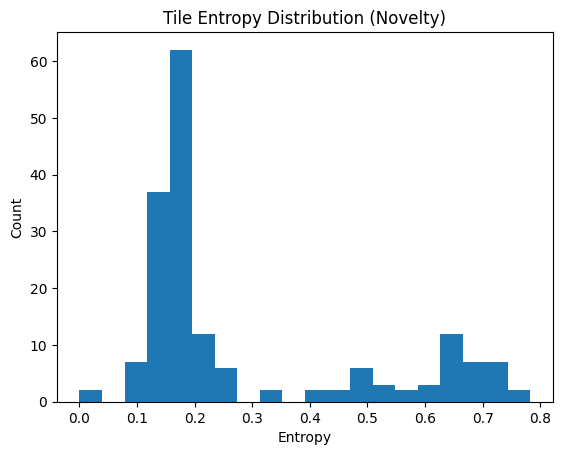

In [5]:
# ============================================================
# 5. Report Summary
# ============================================================

valid_levels = [r for r in results if r["valid"]]
invalid_levels = [r for r in results if not r["valid"]]

print(f"✅ Valid: {len(valid_levels)} | ❌ Invalid: {len(invalid_levels)}")

for r in invalid_levels[:10]:
    print(f"- {r['level']}: {', '.join(r['reasons'])}")

# Save summary JSON
with open("evaluation_summary.json", "w") as f:
    json.dump(results, f, indent=2)

# Plot entropy distribution
plt.hist([r["entropy"] for r in results], bins=20)
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.title("Tile Entropy Distribution (Novelty)")
plt.show()